In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import pandas as pd
import torch

1. Descargue la base de datos Wisconsin Breast Cancer 
1. Construya un regresor logístico en PyTorch
1. Construya un DataSet y DataLoaders de entrenamiento y validación
1. Entrene su modelo, muestre resultados usandos tablas de confusión

--2020-07-03 11:47:02--  https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124103 (121K) [application/x-httpd-php]
Saving to: ‘wdbc.data’

wdbc.data           100%[===================>] 121.19K   211KB/s    in 0.6s    

2020-07-03 11:47:04 (211 KB/s) - ‘wdbc.data’ saved [124103/124103]



<IPython.core.display.Javascript object>


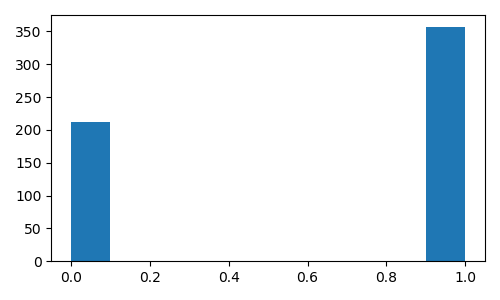

In [2]:
!wget -c https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data

df = pd.read_csv('wdbc.data', index_col=0, header=None)
label = df[1].replace(['M', 'B'], [0, 1]).values.astype('float32')
data = df.loc[:, 2:].values.astype('float32')
fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True)
ax.hist(label);

!rm wdbc.data

In [4]:
# Crear modelo de regresión logística

class Neurona(torch.nn.Module):
    
    def __init__(self, n_input=10):
        super(type(self), self).__init__() 
        self.output = torch.nn.Linear(n_input, 1)        
        self.activation = torch.nn.Sigmoid()
        
    def forward(self, x):
        return self.activation(self.output(x))
        

In [20]:
from torch.utils.data import DataLoader, TensorDataset, Subset 
import sklearn.model_selection


# Crear conjuntos de entrenamiento y validación

sss = sklearn.model_selection.StratifiedShuffleSplit(n_splits=1, train_size=0.8)
train_idx, valid_idx = next(sss.split(data, label))
# Crear dataloaders

torch_dataset = TensorDataset(torch.from_numpy(data),
                              torch.from_numpy(label))

torch_train = Subset(torch_dataset, train_idx)
torch_valid = Subset(torch_dataset, valid_idx)
train_loader = DataLoader(torch_train, batch_size=32, shuffle=True)
valid_loader = DataLoader(torch_valid, batch_size=128, shuffle=False)

In [37]:
# Entrenar modelo, guardar el mejor modelo de validación

model = Neurona(n_input=data.shape[1])
criterion = torch.nn.BCELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

for nepoch in range(10):
    for x, y in train_loader:
        optimizer.zero_grad()
        yhat = model.forward(x)
        loss = criterion(yhat, y)
        loss.backward()
        optimizer.step()
        
    epoch_loss = 0.0
    for x, y in valid_loader:
        yhat = model.forward(x)
        loss = criterion(yhat, y)
        epoch_loss += loss.item()
    print(f"Epoch: {nepoch} Loss valid: {epoch_loss}")
        

Epoch: 0 Loss valid: 1090.704345703125
Epoch: 1 Loss valid: 1137.1864013671875
Epoch: 2 Loss valid: 656.4774780273438
Epoch: 3 Loss valid: 95.54080200195312
Epoch: 4 Loss valid: 141.65533447265625
Epoch: 5 Loss valid: 35.595672607421875
Epoch: 6 Loss valid: 99.38780212402344
Epoch: 7 Loss valid: 32.19586944580078
Epoch: 8 Loss valid: 36.76301574707031
Epoch: 9 Loss valid: 33.26728439331055


In [52]:
yhat = []
yreal = []
for x, y in valid_loader:
    yreal.append(y.detach().numpy())
    yhat.append(model.forward(x).detach().numpy())
    
yhat = np.concatenate(yhat)
yreal = np.concatenate(yreal)

              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95        42
         1.0       0.95      1.00      0.97        72

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



<IPython.core.display.Javascript object>


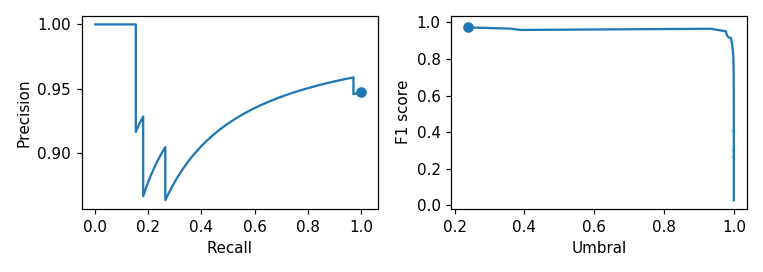

Text(0, 0.5, 'F1 score')

In [79]:
# Evaluar usando matrices de confusión y curvas de desempeño
import sklearn.metrics

print(sklearn.metrics.classification_report(yreal, yhat > 0.2))

prec, rec, th = sklearn.metrics.precision_recall_curve(y_true=yreal, 
                                                       probas_pred=yhat)

fig, ax = plt.subplots(1, 2, figsize=(7, 2.5), tight_layout=True)
ax[0].plot(rec, prec, '-');
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
f1_score = 2*(rec*prec)/(rec+prec)
best = np.argmax(f1_score)
ax[1].plot(th, f1_score[:-1])
ax[1].scatter(th[best], f1_score[best])
ax[0].scatter(rec[best], prec[best])
ax[1].set_xlabel('Umbral')
ax[1].set_ylabel('F1 score')